In [1]:
import warnings
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys
sys.path.append("..")
warnings.simplefilter("ignore")
from Scripts.Data_cleaning import load_data,clean_data
from Scripts.preprocessing import preprocess
from Scripts.modelling import modeler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import pickle
import mlflow 
import mlflow.sklearn 

It is important to process the data into a format where it can be fed to a machine learning model. This typically means converting all non-numeric columns to numeric, handling NaN values and generating new features from already existing features. 

###### Load datasets 

In [2]:
train_df = load_data('../data/train-data.csv')
test_df = load_data('../data/test-data.csv')

###### missing values 

In [3]:
train_df.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Days                         0
months                       0
Years                        0
DayOfYear                    0
WeekOfYear                   0
dtype: int64

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014567 entries, 0 to 1014566
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1014567 non-null  int64  
 1   StoreType                  1014567 non-null  object 
 2   Assortment                 1014567 non-null  object 
 3   CompetitionDistance        1014567 non-null  float64
 4   CompetitionOpenSinceMonth  1014567 non-null  int64  
 5   CompetitionOpenSinceYear   1014567 non-null  int64  
 6   Promo2                     1014567 non-null  int64  
 7   Promo2SinceWeek            1014567 non-null  int64  
 8   Promo2SinceYear            1014567 non-null  int64  
 9   PromoInterval              1014567 non-null  object 
 10  DayOfWeek                  1014567 non-null  int64  
 11  Date                       1014567 non-null  object 
 12  Sales                      1014567 non-null  float64
 13  Customers   

In [5]:
test_df.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Id                           0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Days                         0
months                       0
Years                        0
DayOfYear                    0
WeekOfYear                   0
dtype: int64

##### converting date column to datetime 

In [6]:
c = clean_data(train_df)
c.convert_to_datetime(train_df,['Date'])

In [7]:
d = clean_data(test_df)
d.convert_to_datetime(test_df,['Date'])

###### convert to int 

In [8]:
clean_data(test_df).convert_to_int(test_df,['Days','months','Years','DayOfYear','WeekOfYear'])

###### converting non-numeric to numeric

In [9]:
r = preprocess(train_df)
r.label_encoder(train_df)

In [10]:
train_df.info == 'object'

False

In [11]:
train_df['StoreType'].unique()

array([0, 1, 2, 3], dtype=int64)

all columns in train data have been converted to numeric 

In [12]:
t = preprocess(test_df)
t.label_encoder(test_df)

In [13]:
test_df.info == 'object'

False

all columns in test data have been converted to numeric 

###### feature engineering 

In [14]:
def feat_eng(df):
    df['weekends'] = (df['DayOfWeek']//5 ==1).astype(int)
    df['weekdays'] = (df['DayOfWeek']//5 !=1).astype(int)

In [15]:
feat_eng(train_df)
feat_eng(test_df)

In [16]:
train_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Promo,StateHoliday,SchoolHoliday,Days,months,Years,DayOfYear,WeekOfYear,weekends,weekdays
0,1,0,0,1270.0,9,2008,0,0,0,0,...,1,0,1,31,7,2015,212,31,1,0
1,1,0,0,1270.0,9,2008,0,0,0,0,...,1,0,1,30,7,2015,211,31,0,1
2,1,0,0,1270.0,9,2008,0,0,0,0,...,1,0,1,29,7,2015,210,31,0,1
3,1,0,0,1270.0,9,2008,0,0,0,0,...,1,0,1,28,7,2015,209,31,0,1
4,1,0,0,1270.0,9,2008,0,0,0,0,...,1,0,1,27,7,2015,208,31,0,1


In [17]:
test_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Promo,StateHoliday,SchoolHoliday,Days,months,Years,DayOfYear,WeekOfYear,weekends,weekdays
0,1,0,0,1270.0,9,2008,0,0,0,0,...,1.0,0,0.0,17,9,2015,260,38,0,1
1,1,0,0,1270.0,9,2008,0,0,0,0,...,1.0,0,0.0,16,9,2015,259,38,0,1
2,1,0,0,1270.0,9,2008,0,0,0,0,...,1.0,0,0.0,15,9,2015,258,38,0,1
3,1,0,0,1270.0,9,2008,0,0,0,0,...,1.0,0,0.0,14,9,2015,257,38,0,1
4,1,0,0,1270.0,9,2008,0,0,0,0,...,0.0,0,0.0,13,9,2015,256,37,1,0


###### correlation analysis 

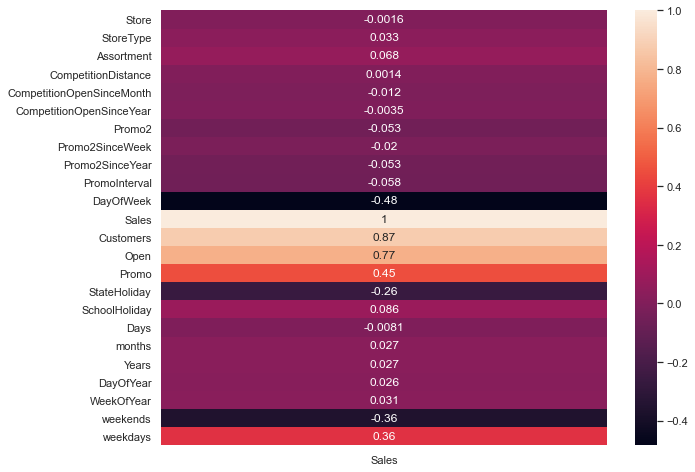

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr()[['Sales']],annot=True);

In [19]:
#select useful cols
use_cols = ['Sales','DayOfWeek','Customers','Open','Promo','StateHoliday','weekends','weekdays']
train_df_use_cols = train_df[use_cols]
train_df_use_cols

,Sales,DayOfWeek,Customers,Open,Promo,StateHoliday,weekends,weekdays
0,5263.0,5,555.0,1,1,0,1,0
1,5020.0,4,546.0,1,1,0,0,1
2,4782.0,3,523.0,1,1,0,0,1
3,5011.0,2,560.0,1,1,0,0,1
4,6102.0,1,612.0,1,1,0,0,1
...,...,...,...,...,...,...,...,...
1014562,4771.0,6,339.0,1,0,0,1,0
1014563,4540.0,5,326.0,1,0,0,1,0
1014564,4297.0,4,300.0,1,0,0,0,1
1014565,3697.0,3,305.0,1,0,0,0,1


###### feature scaling

datetime columns have to be ignored before doing feature scaling 

In [20]:
def separate_columns(df):
    datetime_columm= ['DayOfWeek']
    no_datetime = df.columns.difference(datetime_columm).tolist()
    df_ = df[no_datetime] 
    return df_,datetime_columm

In [21]:
train_df_no_datetime = separate_columns(train_df_use_cols)[0]
# test_df_no_datetime = separate_columns(test_df)[0]


###### scale data 

In [22]:
r.scalling_data(train_df_no_datetime)
# t.scalling_data(test_df_no_datetime)

###### concat scaled data and unscaled data 

In [23]:
train_transformed  = pd.concat([train_df_no_datetime,train_df[separate_columns(train_df)[1]]],axis=1)

# test_transformed = pd.concat([test_df_no_datetime,train_df[separate_columns(test_df)[1]]],axis=1)
train_transformed

,Customers,Open,Promo,Sales,StateHoliday,weekdays,weekends,DayOfWeek
0,0.407489,1.0,1.0,0.433633,0.000000,0.0,1.0,5
1,0.400881,1.0,1.0,0.413611,0.000000,1.0,0.0,4
2,0.383994,1.0,1.0,0.394002,0.000000,1.0,0.0,3
3,0.411160,1.0,1.0,0.412870,0.000000,1.0,0.0,2
4,0.449339,1.0,1.0,0.502760,0.000000,1.0,0.0,1
...,...,...,...,...,...,...,...,...
1014562,0.248899,1.0,0.0,0.393095,0.000000,0.0,1.0,6
1014563,0.239354,1.0,0.0,0.374063,0.000000,0.0,1.0,5
1014564,0.220264,1.0,0.0,0.354041,0.000000,1.0,0.0,4
1014565,0.223935,1.0,0.0,0.304606,0.000000,1.0,0.0,3


In [24]:
train_transformed_ = train_transformed.sample(100000)

# Modelling 

In [25]:
m = modeler()

###### Random forest  

In [26]:
#### split the data
X_train, X_test, X_val, y_train, y_test,y_val = m.split_data(train_transformed_,'Sales')

In [27]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [28]:
estimators = 25
depth = 15
with mlflow.start_run():
    RandomForest_pipeline=Pipeline([
                         ('imputer', SimpleImputer(strategy='mean')),
                        ('scaler',StandardScaler()),
                         ('rf_regressor',RandomForestRegressor( n_estimators=estimators,
                                    max_depth=depth,
                                    min_samples_split=2,
                                    min_samples_leaf=1))])
    
    rf_model = RandomForest_pipeline.fit(X_train,y_train)
    y_pred = rf_model.predict(X_test)
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_param("number of estimators", estimators)
    mlflow.log_param("maximum depth", depth)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    mlflow.sklearn.log_model(rf_model,"Regressor model")

In [29]:
rf_model = RandomForest_pipeline.fit(X_train,y_train)


In [30]:
rf_model.score(X_test,y_test)

0.8279873623380095

##### Feature importance 

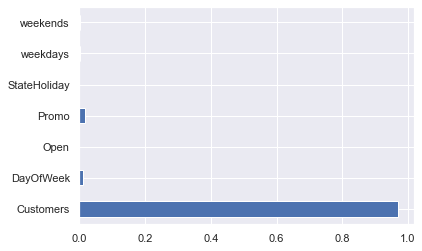

Customers       9.701747e-01
DayOfWeek       1.055997e-02
Open            3.823709e-09
Promo           1.672102e-02
StateHoliday    2.455926e-04
weekdays        1.069111e-03
weekends        1.229563e-03
dtype: float64

In [31]:
#feature importance 
m.feature_importance(RandomForestRegressor,train_transformed_,'Sales')

`Customers` is the most important features 

###### serialize the model

To serve the models you built above, you need to serialize them. Save the model with the timestamp(eg. 10-08-2020-16-32-31-00.pkl). This is necessary so that you can track predictions from various models.


In [32]:
#creating a file name using the created time
filename = '../models/' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + '.pkl'
filename

'../models/2022-06-17-12-37-12.pkl'

In [33]:
with open(filename,'wb') as f:
    pickle.dump(rf_model,f)